In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


from astropy.convolution import convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# initializing parameters:

dataroot='gals/'
device = torch.device("cpu") # If GPU then use "cuda:0"
ngpu = 0 #number of GPUs to use 
nz = 25 #size of the latent z vector
ngf = 64
ndf = 64
workers = 2 #number of data loading workers
batchSize = 25 #input batch size
imageSize = 64 #the height / width of the input image to network
niter = 5 #number of epochs to train for
lr = 0.0002 #learning rate, default=0.0002
beta1 = 0.5 #beta1 for adam. default=0.5
outf='outputs' #folder to output images and model checkpoints


manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  6451


In [14]:
dataset = dset.MNIST(root=dataroot, download=True,
                     transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))


In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [16]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(25, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


torch.Size([25, 1, 17, 17]) (17, 17, 25)


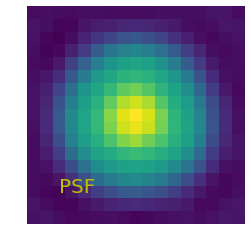

In [19]:
psf = pyfits.getdata('psf_h.fits')
psf = np.asarray(psf[75:-75,75:-75],dtype=float)
psfh_2 = np.repeat(psf[:, :, np.newaxis], batchSize, axis=2)

plt.imshow(np.log10(psf),origin='lower')
plt.axis('off')
plt.text(2,2,'PSF',color='y',size=20)
psf = np.repeat(psf[:, :, np.newaxis], batchSize, axis=2)
psf = np.repeat(psf[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psf)
kernel = kernel.permute(2,3,0,1)

print (np.shape(kernel),np.shape(psfh_2))

torch.Size([25, 1, 64, 64])
torch.Size([25, 1, 17, 17])
torch.Size([25, 25, 48, 48])


/Users/shemmati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


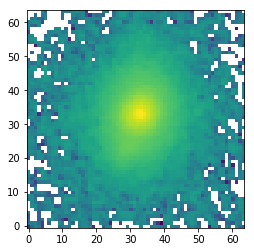

In [20]:
import torch.nn.functional as F


test_im = pyfits.getdata('gal_cutout.fits')
test_im = np.asarray(test_im,dtype=float)
data = np.repeat(test_im[:, :, np.newaxis], batchSize, axis=2)
data = np.repeat(data[:,:,:,np.newaxis],1,axis = 3)
data = torch.Tensor(data)
data = data.permute(2,3,0,1)

output = F.conv2d(data, kernel)

print(data.shape)
print(kernel.shape)
print(output.shape)


plt.imshow(np.log10(test_im),origin='lower')

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        ########## added by Shooby Jun 12 ###############
        
        fd = fake.detach()
        fd = fd.permute(2,3,0,1)
        fd = fd.reshape(fd.shape[0],fd.shape[1],batchSize)
        fn = fd.data.numpy()
        fn = convolve(fn,psfh_2)
        fd = torch.from_numpy(fn)
        fd = fd.reshape(fd.shape[0],fd.shape[1],batchSize,nc)
        fd = fd.permute(2,3,0,1)
        #### added June 13
        #fd = F.conv2d(fd, kernel)

        #################################################
        
        output = netD(fd)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/5][0/241] Loss_D: 2.4630 Loss_G: 2.4839 D(x): 0.7711 D(G(z)): 0.8349 / 0.1379
[0/5][1/241] Loss_D: 0.1384 Loss_G: 0.5244 D(x): 0.9314 D(G(z)): 0.0534 / 0.6309
[0/5][2/241] Loss_D: 2.1158 Loss_G: 0.3370 D(x): 0.9345 D(G(z)): 0.8476 / 0.7426
[0/5][3/241] Loss_D: 0.3643 Loss_G: 0.1064 D(x): 0.8481 D(G(z)): 0.0581 / 0.9075
[0/5][4/241] Loss_D: 0.1960 Loss_G: 0.0572 D(x): 0.9153 D(G(z)): 0.0120 / 0.9485
[0/5][5/241] Loss_D: 0.0110 Loss_G: 0.0438 D(x): 0.9949 D(G(z)): 0.0058 / 0.9603
[0/5][6/241] Loss_D: 0.0685 Loss_G: 0.0098 D(x): 0.9555 D(G(z)): 0.0039 / 0.9903
[0/5][7/241] Loss_D: 0.0128 Loss_G: 0.0092 D(x): 0.9981 D(G(z)): 0.0108 / 0.9909
[0/5][8/241] Loss_D: 0.0068 Loss_G: 0.0109 D(x): 0.9988 D(G(z)): 0.0056 / 0.9892
[0/5][9/241] Loss_D: 0.0019 Loss_G: 0.0097 D(x): 1.0000 D(G(z)): 0.0019 / 0.9905
